In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_parquet('./Data/draft0522.parquet')

In [3]:
model_df = df.drop(['school_name'],axis=1)

In [4]:
model_df.Round[model_df.Round <= 3] = 2

C:\Users\capta\AppData\Local\Temp\ipykernel_15748\2943970229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round <= 3] = 2


In [5]:
model_df.Round[model_df.Round == 8] = 0

C:\Users\capta\AppData\Local\Temp\ipykernel_15748\3023946570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round == 8] = 0


In [6]:
model_df.Round[model_df.Round >=4] = 1

C:\Users\capta\AppData\Local\Temp\ipykernel_15748\4119251177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round >=4] = 1


In [7]:
model_df.Round.value_counts(normalize=True)

0.0    0.358002
1.0    0.349761
2.0    0.292237
Name: Round, dtype: float64

In [8]:
X = model_df.drop(['Round'],axis=1)
y = model_df.Round

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team

X_train.drop(['player','pick','year','team'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = Pipeline(steps=[
    ('trans',transformer),
    ('gaus',GaussianMixture(random_state=42))])

grid = {'gaus__n_components':[4,5,6,7,8,9,10]}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler()),
                                                                                         ('impute',
                                                                                          SimpleImputer(strategy='constant'))]),
                                                                         Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'd...
       'fumbles_forced_season', 'fumbles_forced_career', 'Age', 'speed',
       'agility', 'alt_agility'],
      dtype='object')),
              

In [10]:
gridsearch.best_params_

{'gaus__n_components': 4}

In [11]:
gridsearch.n_splits_

5

In [12]:
gridsearch.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'def_int_career', 'def_int_yds_...
       'tackles_loss_career', 'sacks_career', 'pass_defended_career',
       'fumbles_forced_season', 'fumbles_forced_career', 'Age', 'speed',
       'agility', 'alt_agility'],
      dtype='object')),
                                                 ('cat',
                                      

In [13]:
from copy import deepcopy
preprocess = deepcopy(gridsearch.best_estimator_)

preprocess.steps.pop()

('gaus', GaussianMixture(n_components=4, random_state=42))

In [14]:
X_transformed = preprocess.transform(X_train)

In [15]:
gridsearch.best_estimator_[-1].aic(X_transformed)

-2994240.2315481342

In [16]:
gridsearch.best_estimator_[-1].bic(X_transformed)

-2745130.781855205

In [17]:
y_pred = gridsearch.predict_proba(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [18]:
y_pred_df = pd.DataFrame(y_pred)

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(random_state=42,learning_rate=100)
tsne_y_pred = tsne.fit_transform(y_pred_df)
tsne_y_pred = pd.DataFrame(tsne_y_pred, columns = ['TSNE1','TSNE2'])

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [21]:
tsne_y_pred['group'] = np.argmax(y_pred_df.values, axis = 1)

In [22]:
tsne_x = transformer.fit_transform(X_test)
tsne_x = tsne.fit_transform(tsne_x)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [23]:
tsne_xs = pd.DataFrame(tsne_x, columns = ['TSNE1','TSNE2'])

In [25]:
x_tsne = pd.concat([tsne_xs,tsne_y_pred['group']],axis=1)

In [26]:
look = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),tsne_y_pred.reset_index()],axis=1)

In [27]:
relook = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),x_tsne.reset_index()],axis=1)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

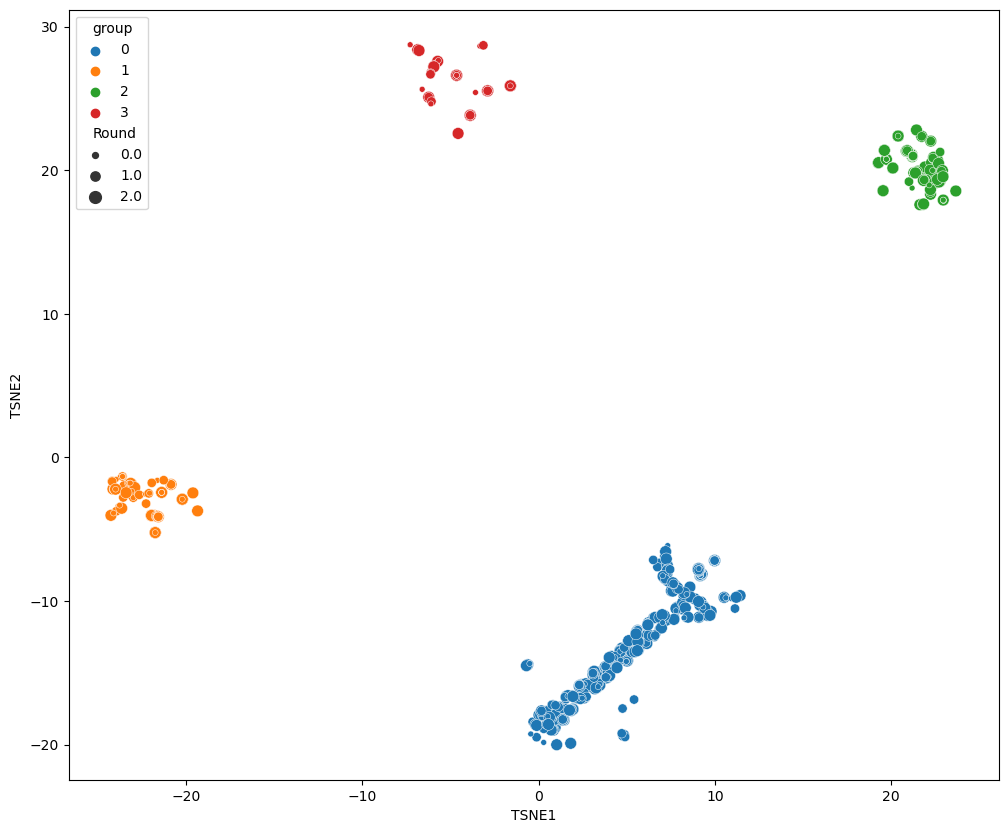

In [49]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=tsne_y_pred.TSNE1,y=tsne_y_pred.TSNE2, hue=tsne_y_pred['group'], palette = 'tab10',size=look.Round);

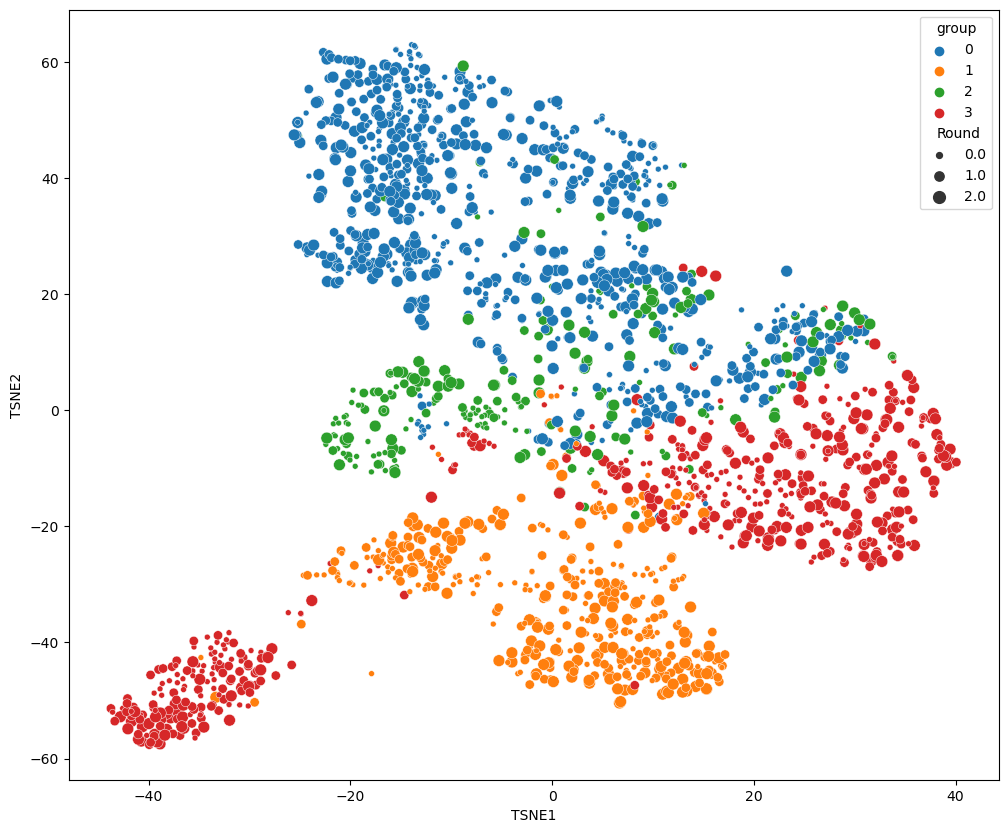

In [30]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=x_tsne.TSNE1,y=x_tsne.TSNE2, hue=x_tsne['group'], palette = 'tab10',size=look.Round);

In [71]:
relook.groupby('group').pos.value_counts()

group  pos 
0      OL      330
       LB      165
       DT      130
       DE       98
       DL       52
       LS        9
       QB        9
       TE        3
       CB        1
1      WR      292
       TE       98
       FB       23
2      QB       87
       LB       59
       P        36
       EDGE     22
       DE       14
       DT        7
       WR        6
       FB        3
       OL        2
       TE        2
       RB        1
3      CB      175
       RB      173
       S       144
       K        27
       DB       16
       LB       12
       WR        4
       LS        2
       QB        1
Name: pos, dtype: int64

In [77]:
clump2_l = relook[(relook.TSNE2 < 15) & (relook.group == 2) & (relook.TSNE1 < -8)]

In [78]:
clump2_l.pos.value_counts()

QB    77
P      7
WR     4
FB     1
Name: pos, dtype: int64

In [72]:
clump1_lt = relook[(relook.TSNE2 < -15) & (relook.TSNE2 > -32) & (relook.group == 1) & (relook.TSNE1 < -5)]

In [66]:
clump1_lt.pos.value_counts()

TE    80
FB    17
WR    14
Name: pos, dtype: int64

In [75]:
clump1_rb = relook[(relook.TSNE2 < -12) & (relook.group == 1) & (relook.TSNE1 >= -5)]

In [76]:
clump1_rb.pos.value_counts()

WR    267
TE      7
FB      3
Name: pos, dtype: int64

In [55]:
clump0_b = relook[(relook.TSNE2 < 15) & (relook.group == 0)]

In [57]:
clump0_b.pos.value_counts()

LB    131
DE     11
QB      8
LS      7
DL      3
TE      2
OL      2
DT      2
CB      1
Name: pos, dtype: int64

In [56]:
clump0_t = relook[(relook.TSNE2 >= 15) & (relook.group == 0)]

In [58]:
clump0_t.pos.value_counts()

OL    328
DT    128
DE     87
DL     49
LB     34
LS      2
TE      1
QB      1
Name: pos, dtype: int64

In [92]:
clump3_ml = relook[(relook.TSNE1 < -5) & (relook.TSNE2 > -20) & (relook.group == 3)]

In [93]:
clump3_ml.pos.value_counts()

K     14
DB     3
S      2
QB     1
Name: pos, dtype: int64

In [88]:
clump3_bl = relook[(relook.TSNE1 < -20) & (relook.group == 3)]

In [90]:
clump3_bl.pos.value_counts()

RB    159
CB      2
S       1
Name: pos, dtype: int64

In [50]:
clump3_r = relook[(relook.TSNE1 > -20) & (relook.group == 3)]

In [51]:
clump3_r.pos.value_counts()

CB    173
S     143
K      27
DB     16
RB     14
LB     12
WR      4
LS      2
QB      1
Name: pos, dtype: int64

In [83]:
clump3_bl.describe()

,index,index,pick,index,index,year,index,Round,index,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2,group
count,162.000000,162.000000,102.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,161.000000,161.000000,155.000000,136.000000,122.000000,131.000000,96.000000,96.000000,161.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.000000,159.000000,159.000000,157.000000,155.000000,155.000000,155.000000,159.000000,159.000000,159.000000,158.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,133.000000,162.000000,162.000000,162.000000,162.000000,0.0,0.0,88.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.000000,154.000000,96.000000,95.000000,162.000000,162.000000,162.000000,162.0
mean,2860.006173,2860.006173,124.009804,2860.006173,2860.006173,2013.222222,2860.006173,0.845679,2860.006173,70.416149,213.832298,4.540774,34.632353,19.377049,118.709924,7.047917,4.278542,11.459627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.257862,1021.012579,5.252830,10.318471,20.077419,175.761290,8.595484,211.830189,1192.352201,5.594969,11.240506,476.987654,2563.413580,5.401852,24.666667,50.870370,449.604938,8.776543,3.195489,527.858025,3013.018519,5.748765,27.246914,NaN,NaN,1.772727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.979592,100.873441,128.756079,122.110180,1020.648148,-35.133877,-47.989029,3.0
std,1780.215405,1780.215405,64.449458,1780.215405,1780.215405,5.355673,1780.215405,0.752396,1780.215405,1.671672,12.343640,0.105483,2.844250,4.150730,5.964625,0.185727,0.144957,2.387451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.509669,471.804494,0.862863,6.100692,10.804962,110.780119,2.754037,84.533733,522.027221,0.857048,6.363141,179.363089,981.158237,0.718044,11.968904,30.143578,284.945813,1.853368,2.400943,193.328410,1103.462599,0.709583,12.619644,NaN,NaN,1.161917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896495,9.408772,17.397139,11.241148,567.553806,4.429130,5.612877,0.0
min,12.000000,12.000000,3.000000,12.000000,12.000000,2005.000000,12.000000,0.000000,12.000000,66.000000,187.000000,4.310000,27.500000,6.000000,98.000000,6.650000,3.960000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,73.000000,2.800000,1.000000,1.000000,1.000000,1.000000,18.000000,95.000000,3.100000,1.000

In [53]:
pd.set_option("display.max_columns", None)
clump3_r.describe()

,index,index,pick,index,index,year,index,Round,index,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2,group
count,392.000000,392.000000,244.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,389.000000,390.000000,360.000000,297.000000,290.000000,293.000000,209.000000,214.000000,307.000000,271.000000,222.000000,222.000000,304.000000,282.000000,282.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,2.000000,1.0,3.000000,3.000000,3.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000,4.00000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,41.000000,53.000000,3.000000,71.000000,128.000000,115.000000,13.000000,18.0,61.000000,288.000000,286.000000,288.000000,261.000000,106.000000,173.000000,292.000000,292.000000,292.000000,287.000000,182.000000,213.000000,72.000000,150.000000,240.000000,358.000000,214.000000,208.000000,392.000000,392.000000,392.000000,392.0
mean,3045.380102,3045.380102,107.032787,3045.380102,3045.380102,2013.709184,3045.380102,0.918367,3045.380102,71.622108,200.882051,4.541444,35.715488,16.510345,121.385666,6.997081,4.199766,11.807818,2.708487,46.554054,18.256306,6.026316,92.024823,15.264894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.333333,38.333333,5.300000,3.0,34.333333,486.666667,11.666667,25.000000,393.750000,10.875000,3.250000,72.000000,452.333333,6.950000,9.000000,50.50000,715.750000,12.875000,5.250000,83.600000,1055.000000,10.375000,9.750000,36.585366,1.132075,3.333333,1.197183,1.468750,1.765217,34.769231,1.0,1.163934,38.986111,19.846154,58.694444,3.785441,1.660377,6.040462,101.085616,50.667808,151.753425,8.210801,2.543956,13.300469,1.458333,2.113333,22.320833,95.280752,130.691245,118.086190,1008.698980,21.771036,-10.994345,3.0
std,1798.411705,1798.411705,63.573157,1798.411705,1798.411705,5.396989,1798.411705,0.817625,1798.411705,1.807380,15.147312,0.147121,2.963864,4.480820,5.945362,0.211532,0.146664,2.103266,1.699641,41.182677,15.839784,3.424716,75.313268,10.707217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.214550,69.866539,7.778175,NaN,49.237520,760.111395,4.163332,39.849718,647.354295,2.970269,3.304038,110.869292,722.164340,0.777817,9.899495,64.52648,1019.523214,4.317696,5.439056,96.983504,1069.243658,3.993641,9.844626,25.106748,0.341813,4.041452,0.434896,0.802923,1.094888,23.367192,0.0,0.453884,14.972675,11.901530,24.478043,3.093408,1.479297,3.348652,44.965617,33.258375,73.437826,7.243757,3.441017,8.020837,0.767977,1.430899,0.882882,11.669283,20.480607,12.953791,5

In [35]:
look.groupby('group').mean()

C:\Users\capta\AppData\Local\Temp\ipykernel_15748\1321038469.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  look.groupby('group').mean()


,index,index,pick,index,index,year,index,Round,index,height,...,pass_defended_career,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2
group,,,,,,,,,,,,,,,,,,,,,
0,2989.549561,2989.549561,114.591497,2989.549561,2989.549561,2013.549561,2989.549561,1.001255,2989.549561,75.505675,...,4.335312,1.855615,2.881119,22.577143,90.528467,131.012585,133.312529,970.834379,6.512532,-11.481613
1,2991.239709,2991.239709,122.207031,2991.239709,2991.239709,2013.571429,2991.239709,0.893462,2991.239709,73.578049,...,NaN,NaN,NaN,22.306452,98.568437,128.782651,125.649650,1043.891041,-21.879374,-4.386141
2,2838.548117,2838.548117,112.013986,2838.548117,2838.548117,2013.096234,2838.548117,0.891213,2838.548117,74.372385,...,4.986842,2.222222,3.382353,22.613139,90.229109,133.819063,128.919845,1001.531381,21.311026,20.718811
3,2991.173285,2991.173285,112.037572,2991.173285,2991.173285,2013.566787,2991.173285,0.897112,2991.173285,71.269091,...,13.300469,1.458333,2.113333,22.221893,96.962928,130.091968,119.347837,1012.193141,-2.790841,25.628412


In [36]:
group0 = look[look.group == 0]
group1 = look[look.group == 1]
group2 = look[look.group == 2]
group3 = look[look.group == 3]

In [37]:
group0.pos.value_counts(normalize=True)

OL    0.414053
LB    0.207026
DT    0.163112
DE    0.122961
DL    0.065245
QB    0.011292
LS    0.011292
TE    0.003764
CB    0.001255
Name: pos, dtype: float64

In [38]:
group1.pos.value_counts(normalize=True)

WR    0.707022
TE    0.237288
FB    0.055690
Name: pos, dtype: float64

In [39]:
group2.pos.value_counts(normalize=True)

QB      0.364017
LB      0.246862
P       0.150628
EDGE    0.092050
DE      0.058577
DT      0.029289
WR      0.025105
FB      0.012552
OL      0.008368
TE      0.008368
RB      0.004184
Name: pos, dtype: float64

In [40]:
group3.pos.value_counts(normalize=True)

CB    0.315884
RB    0.312274
S     0.259928
K     0.048736
DB    0.028881
LB    0.021661
WR    0.007220
LS    0.003610
QB    0.001805
Name: pos, dtype: float64

In [42]:
look.groupby('group').tackles_total_season.mean()

group
0    53.065657
1          NaN
2    69.453608
3    58.694444
Name: tackles_total_season, dtype: float64

In [44]:
look.groupby('group').bench_reps.mean()

group
0    24.707237
1    16.532143
2    22.231579
3    17.359223
Name: bench_reps, dtype: float64

In [45]:
look.groupby('group').weight.mean()

group
0    287.857683
1    216.219512
2    233.531381
3    204.666062
Name: weight, dtype: float64

In [46]:
look.groupby('group').height.mean()

group
0    75.505675
1    73.578049
2    74.372385
3    71.269091
Name: height, dtype: float64

In [47]:
look.groupby('group').rec_career.mean()

group
0           NaN
1    118.905660
2           NaN
3     50.861446
Name: rec_career, dtype: float64

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as iPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6067 entries, 0 to 6066
Data columns (total 89 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       6067 non-null   object 
 1   year                         6067 non-null   float64
 2   pos                          6067 non-null   object 
 3   height                       6038 non-null   float64
 4   weight                       6043 non-null   float64
 5   forty_yd                     5619 non-null   float64
 6   vertical                     4780 non-null   float64
 7   bench_reps                   4173 non-null   float64
 8   broad_jump                   4700 non-null   float64
 9   cone                         3819 non-null   float64
 10  shuttle                      3923 non-null   float64
 11  g_season                     4311 non-null   float64
 12  def_int_season               1285 non-null   float64
 13  def_int_yds_season

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)
under_samp = RandomUnderSampler(random_state=42)

X_train.drop(['player','pick','year','team'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = iPipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = iPipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = iPipeline(steps=([
    ('trans',transformer),
    ('smote',smote),
    ('over_samp',over_samp),
    ('under_samp',under_samp),
    ('tree',DecisionTreeClassifier(random_state=42))
]))

grid = {
    'tree__criterion':['gini','entropy','log_loss'],
    'tree__max_depth':[4,8,12,None],
    'tree__min_samples_split':[2,3,4],
    'tree__min_samples_leaf':[1,2,3]
}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

y_pred = gridsearch.predict(X_test)

gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'tree__criterion': 'entropy',
 'tree__max_depth': 4,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 2}

C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


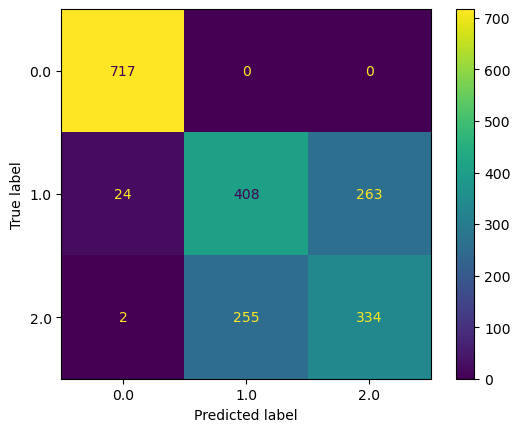

In [100]:
plot_confusion_matrix(gridsearch,X_test,y_test)

In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       717
         1.0       0.62      0.59      0.60       695
         2.0       0.56      0.57      0.56       591

    accuracy                           0.73      2003
   macro avg       0.71      0.72      0.72      2003
weighted avg       0.72      0.73      0.73      2003

